#### IMPORTS

In [1]:
import torch
import numpy as np

from dataloader import MyCustomDataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim

import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
default_dir = os.getcwd()
def default_directory():
    os.chdir(f"{default_dir}")
    print(f"you are back to the default directory: {default_dir}")


In [3]:
default_directory()
os.getcwd()

you are back to the default directory: /home/karansingh/Documents/summer term/ECG_ML/MAIN


'/home/karansingh/Documents/summer term/ECG_ML/MAIN'

`changing directory to /home/karansingh/Documents/summer term/ECG_ML/MAIN/ML/data_4 where superposition image of type 2 is located`


In [4]:
os.chdir("ML/data_unq_50")
os.getcwd()

'/home/karansingh/Documents/summer term/ECG_ML/MAIN/ML/data_unq_50'

#### LOAD DATA

In [5]:
## Create fake dataset for demonstration purposes

## Load your dataset and use 


data_ST_list = []
for i in range(10):
    cc = np.loadtxt('unq_50_disease_ST_svd_'+str(i)+'.txt')
    data_ST_list.append(cc)
    print(f"data st of length {len(cc)} in {i} index loaded")


data_ST_list = np.array(data_ST_list)
images = np.resize(data_ST_list,(3000,2500))

labels=np.zeros(3000)

data_SB_list = []
for i in range(10):
    cc = np.loadtxt('unq_50_disease_SB_svd_'+str(i)+'.txt')
    data_SB_list.append(cc)
    print(f"data sb of length {len(cc)} in {i} index loaded")
images = np.concatenate((images,np.resize(data_SB_list,(5000,2500))))
labels=np.concatenate((labels,np.ones(5000)))

data_SR_list = []
for i in range(10):
    cc = np.loadtxt('unq_50_disease_SR_svd_'+str(i)+'.txt')
    data_SR_list.append(cc)
    print(f"data sr of length {len(cc)} in {i} index loaded")
images = np.concatenate((images,np.resize(data_SR_list,(5000,2500))))
labels=np.concatenate((labels,np.ones(5000)*2))
                    

data st of length 300 in 0 index loaded
data st of length 300 in 1 index loaded
data st of length 300 in 2 index loaded
data st of length 300 in 3 index loaded
data st of length 300 in 4 index loaded
data st of length 300 in 5 index loaded
data st of length 300 in 6 index loaded
data st of length 300 in 7 index loaded
data st of length 300 in 8 index loaded
data st of length 300 in 9 index loaded
data sb of length 500 in 0 index loaded
data sb of length 500 in 1 index loaded
data sb of length 500 in 2 index loaded
data sb of length 500 in 3 index loaded
data sb of length 500 in 4 index loaded
data sb of length 500 in 5 index loaded
data sb of length 500 in 6 index loaded
data sb of length 500 in 7 index loaded
data sb of length 500 in 8 index loaded
data sb of length 500 in 9 index loaded
data sr of length 500 in 0 index loaded
data sr of length 500 in 1 index loaded
data sr of length 500 in 2 index loaded
data sr of length 500 in 3 index loaded
data sr of length 500 in 4 index loaded


In [6]:
default_directory()
print(len(images),len(labels))
from model_cnn import SmallCNN50
print(images.shape)
images = images.reshape(13000,1,50,50)
images.shape



you are back to the default directory: /home/karansingh/Documents/summer term/ECG_ML/MAIN
13000 13000
(13000, 2500)


(13000, 1, 50, 50)

#### CREATE BATCHES

In [7]:
# Create an instance of your dataset

images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)
train_dataset = MyCustomDataset(images_train, labels_train)
test_dataset = MyCustomDataset(images_test, labels_test)
# Define a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### TRAINING

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2,2)
        self.dropout_conv = nn.Dropout2d(0.2)
        self.dropout_fc = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128*6*6, 512)
        self.fc2 = nn.Linear(512, 3)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128*6*6)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x



In [11]:
import copy
import torch
import torch.nn as nn
from model_cnn import SmallCNN50


torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SmallCNN50().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)

# Scheduler (reduce LR when test loss plateaus)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

def correct(pred, true): 
    return (pred == true).sum().item()

num_epochs, patience = 25, 7
train_losses_list, test_losses_list, accuracy_train_list, accuracy_test_list = [], [], [], []
best_acc, wait, best_model = 0, 0, None

for epoch in range(num_epochs):
    # --- Train ---
    model.train(); run_loss = 0; c_train = t_train = 0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        out = model(x); loss = criterion(out, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        run_loss += loss.item()
        c_train += correct(out.argmax(1), y); t_train += y.size(0)
    train_losses_list.append(run_loss/len(train_dataloader))
    accuracy_train_list.append(100*c_train/t_train)

    # --- Test ---
    model.eval(); run_loss = 0; c_test = t_test = 0
    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x); loss = criterion(out, y)
            run_loss += loss.item()
            c_test += correct(out.argmax(1), y); t_test += y.size(0)
    test_losses_list.append(run_loss/len(test_dataloader))
    accuracy_test_list.append(100*c_test/t_test)

    # --- LR scheduler step ---
    scheduler.step(test_losses_list[-1])
    # Print LR (optional)
    lr_now = optimizer.param_groups[0]['lr']

    # --- Early stopping ---
    if accuracy_test_list[-1] > best_acc:
        best_acc, wait = accuracy_test_list[-1], 0
        best_model = copy.deepcopy(model.state_dict())
    else:
        wait += 1
        if wait >= patience:
            print(f"##Early stopping at epoch {epoch+1}##")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_losses_list[-1]:.4f}, Test Loss: {test_losses_list[-1]:.4f}, "
          f"Train Acc: {accuracy_train_list[-1]:.2f}, Test Acc: {accuracy_test_list[-1]:.2f}, "
          f"LR: {lr_now:.6f}")

# Restore best weights
model.load_state_dict(best_model)
print(f" Best Test Accuracy: {best_acc:.2f}")


Epoch [1/25] | Train Loss: 0.9264, Test Loss: 0.7792, Train Acc: 53.58, Test Acc: 69.65, LR: 0.000100
Epoch [2/25] | Train Loss: 0.7448, Test Loss: 0.6346, Train Acc: 67.45, Test Acc: 73.96, LR: 0.000100
Epoch [3/25] | Train Loss: 0.6060, Test Loss: 0.5057, Train Acc: 75.34, Test Acc: 79.27, LR: 0.000100
Epoch [4/25] | Train Loss: 0.5013, Test Loss: 0.4246, Train Acc: 79.88, Test Acc: 82.54, LR: 0.000100
Epoch [5/25] | Train Loss: 0.4190, Test Loss: 0.3452, Train Acc: 84.11, Test Acc: 86.23, LR: 0.000100
Epoch [6/25] | Train Loss: 0.3575, Test Loss: 0.2961, Train Acc: 86.31, Test Acc: 87.77, LR: 0.000100
Epoch [7/25] | Train Loss: 0.3121, Test Loss: 0.2693, Train Acc: 88.09, Test Acc: 89.46, LR: 0.000100
Epoch [8/25] | Train Loss: 0.2741, Test Loss: 0.2498, Train Acc: 89.57, Test Acc: 90.15, LR: 0.000100
Epoch [9/25] | Train Loss: 0.2676, Test Loss: 0.2135, Train Acc: 90.02, Test Acc: 92.50, LR: 0.000100
Epoch [10/25] | Train Loss: 0.2417, Test Loss: 0.2006, Train Acc: 90.84, Test Acc:

In [12]:
import copy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# === CONFIG ===
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs, patience = 25, 7
seeds = range(20, 60)   # from 20 to 60

# To store results for all seeds
all_train_losses, all_test_losses = {}, {}
all_train_acc, all_test_acc = {}, {}

best_acc_overall, best_seed, best_model_state = 0, None, None

def correct(pred, true): 
    return (pred == true).sum().item()

# === LOOP OVER SEEDS ===
for seed in seeds:
    torch.manual_seed(seed)

    # Model, optimizer, scheduler
    model = SmallCNN50().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=3
    )

    # Logs for this run
    train_losses_list, test_losses_list = [], []
    accuracy_train_list, accuracy_test_list = [], []

    best_acc, wait, best_model = 0, 0, None

    for epoch in range(num_epochs):
        # --- Train ---
        model.train(); run_loss = 0; c_train = t_train = 0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x); loss = criterion(out, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            run_loss += loss.item()
            c_train += correct(out.argmax(1), y); t_train += y.size(0)
        train_losses_list.append(run_loss/len(train_dataloader))
        accuracy_train_list.append(100*c_train/t_train)

        # --- Test ---
        model.eval(); run_loss = 0; c_test = t_test = 0
        with torch.no_grad():
            for x, y in test_dataloader:
                x, y = x.to(device), y.to(device)
                out = model(x); loss = criterion(out, y)
                run_loss += loss.item()
                c_test += correct(out.argmax(1), y); t_test += y.size(0)
        test_losses_list.append(run_loss/len(test_dataloader))
        accuracy_test_list.append(100*c_test/t_test)

        # --- LR schedule ---
        scheduler.step(test_losses_list[-1])

        # --- Early stopping ---
        if accuracy_test_list[-1] > best_acc:
            best_acc, wait = accuracy_test_list[-1], 0
            best_model = copy.deepcopy(model.state_dict())
            if best_acc > 98.6:
                print(f"Seed {seed}: Early stopping at epoch {epoch+1}")
                break
        else:
            wait += 1
            if wait >= patience:
                print(f"Seed {seed}: Early stopping at epoch {epoch+1}")
                break

    # Save results for this seed
    all_train_losses[seed] = train_losses_list
    all_test_losses[seed] = test_losses_list
    all_train_acc[seed] = accuracy_train_list
    all_test_acc[seed] = accuracy_test_list

    # Check if this seed gave the best accuracy overall
    if best_acc > best_acc_overall:
        best_acc_overall, best_seed = best_acc, seed
        best_model_state = best_model

    print(f"Seed {seed}: Best Test Accuracy = {best_acc:.2f}")

# === Save best model ===
torch.save(best_model_state, f"best_model_seed_{best_seed}.pth")
print(f"\nBest overall seed = {best_seed}, Accuracy = {best_acc_overall:.2f}")


Seed 20: Early stopping at epoch 25
Seed 20: Best Test Accuracy = 96.96
Seed 21: Early stopping at epoch 25
Seed 21: Best Test Accuracy = 97.04
Seed 22: Early stopping at epoch 21
Seed 22: Best Test Accuracy = 96.85
Seed 23: Early stopping at epoch 21
Seed 23: Best Test Accuracy = 96.69
Seed 24: Early stopping at epoch 25
Seed 24: Best Test Accuracy = 96.85
Seed 25: Early stopping at epoch 23
Seed 25: Best Test Accuracy = 96.88
Seed 26: Best Test Accuracy = 96.77
Seed 27: Early stopping at epoch 18
Seed 27: Best Test Accuracy = 97.12
Seed 28: Early stopping at epoch 19
Seed 28: Best Test Accuracy = 97.08
Seed 29: Best Test Accuracy = 97.08
Seed 30: Early stopping at epoch 14
Seed 30: Best Test Accuracy = 96.65
Seed 31: Early stopping at epoch 14
Seed 31: Best Test Accuracy = 96.92
Seed 32: Best Test Accuracy = 97.35
Seed 33: Early stopping at epoch 21
Seed 33: Best Test Accuracy = 96.92
Seed 34: Early stopping at epoch 20
Seed 34: Best Test Accuracy = 96.65
Seed 35: Early stopping at e

In [13]:
import pickle
import os
import ipynbname

# Get current notebook name
try:
    # Get notebook name (without .ipynb extension)
    notebook_name = ipynbname.name()

except:
    notebook_name = "Notebook"  # fallback if can't get notebook name

# Create folder with notebook name if it doesn't exist
if not os.path.exists(notebook_name):
    os.makedirs(notebook_name)

# Path to save
save_path = os.path.join(notebook_name, "all_results.pkl")

# Save results
results = {
    "train_losses": all_train_losses,
    "test_losses": all_test_losses,
    "train_acc": all_train_acc,
    "test_acc": all_test_acc,
    "best_seed": best_seed,
    "best_acc": best_acc_overall,
}

with open(save_path, "wb") as f:
    pickle.dump(results, f)

torch.save(best_model_state, os.path.join(notebook_name, f"best_model{best_seed}.pth"))

print(f" Saved all training histories to {save_path}")


 Saved all training histories to main_1_cnn50/all_results.pkl


In [15]:
# === Instantiate a new model object ===
model = SmallCNN50().to(device)

# === Load the best saved state dict ===
model.load_state_dict(best_model_state)

# === Set to evaluation mode ===
model.eval()

print(f"Loaded best model from seed {best_seed} with accuracy {best_acc_overall:.2f}")


Loaded best model from seed 32 with accuracy 97.35


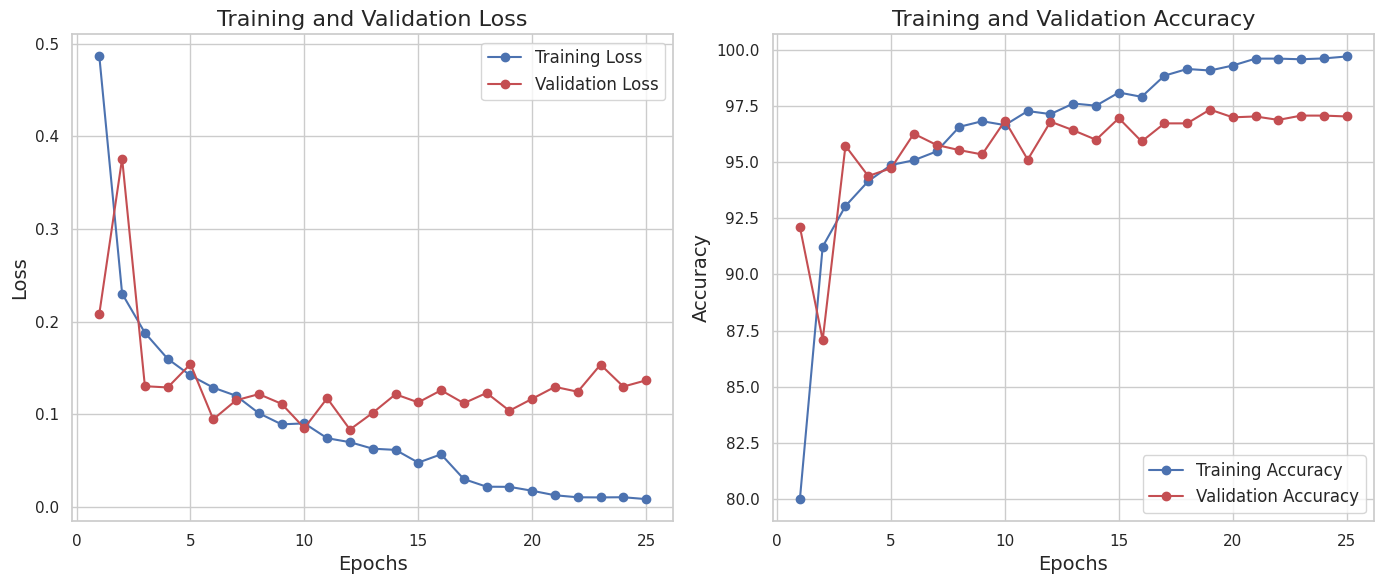

In [16]:
from plots import accuracy_and_validation_plots
epochs_= list(range(1, len(all_train_losses[best_seed])+1))
accuracy_and_validation_plots(epochs_,
    all_train_losses[best_seed],
    all_test_losses[best_seed],
    all_train_acc[best_seed],
    all_test_acc[best_seed]
).plot_figure("accuracy.png")


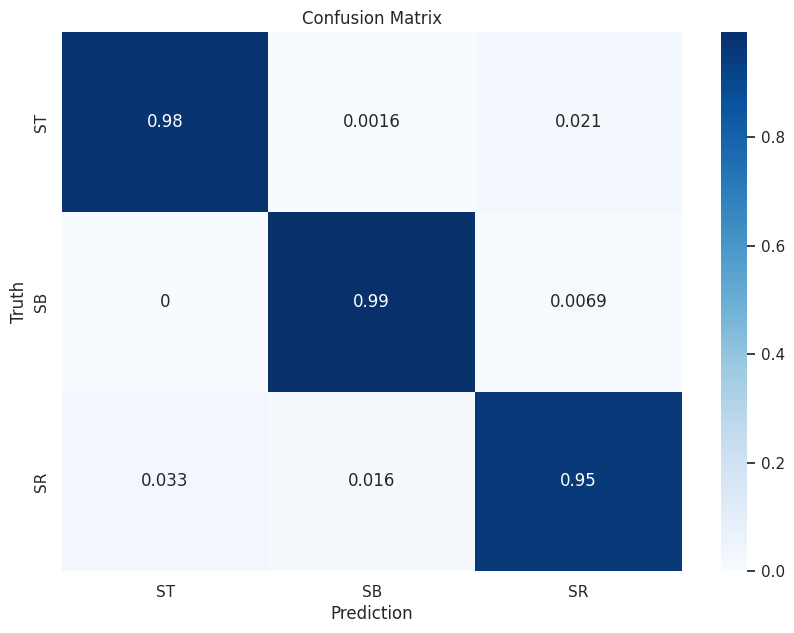

In [17]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import torch.nn.functional as F

model.eval()
y_pred = []
y_true = []
y_scores = []  # Added to collect probability scores

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images.to(device))
        # Get probability scores using softmax
        probabilities = F.softmax(outputs, dim=1)
        y_scores.extend(probabilities.cpu().numpy())
        
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_scores = np.array(y_scores)

cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix
df_cm = pd.DataFrame(cm, index=["ST", "SB", "SR"], columns=["ST", "SB", "SR"])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

In [18]:

#Classification Report for Test Data:

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["ST", "SB", "SR"]))


              precision    recall  f1-score   support

          ST       0.95      0.98      0.96       614
          SB       0.98      0.99      0.99      1015
          SR       0.98      0.95      0.96       971

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



Average precision score, micro-averaged over all classes: 1.00


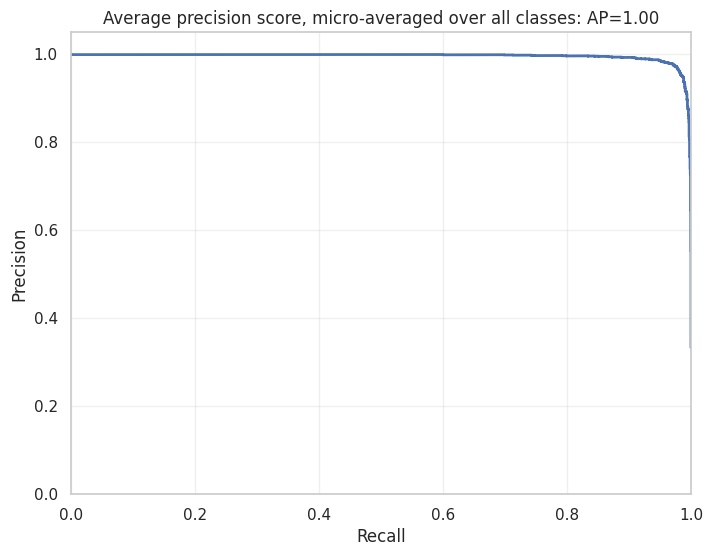

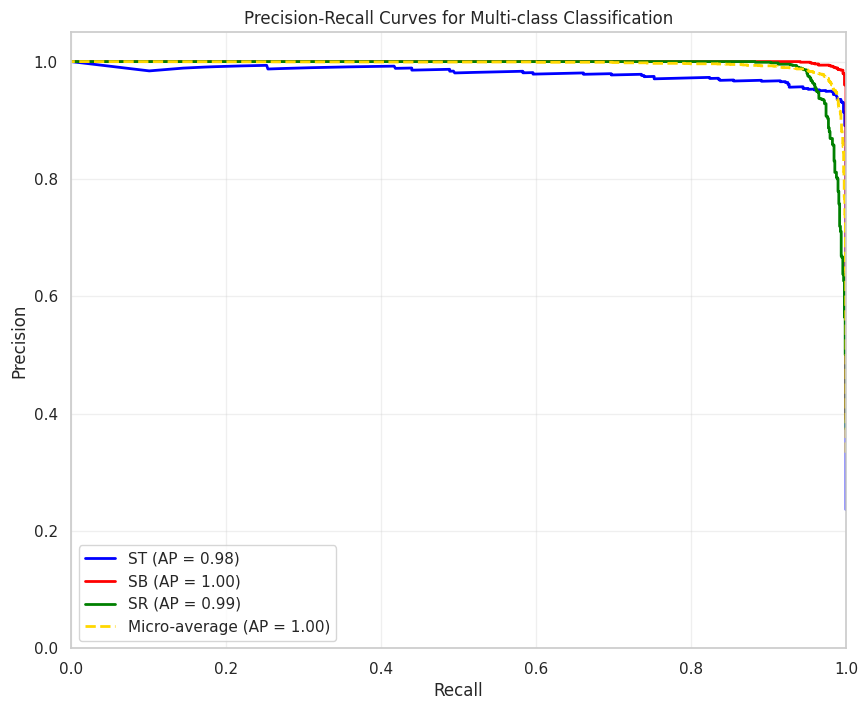

In [19]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()

# For each class, compute PR curve using probability scores
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(
        (np.array(y_true) == i).astype(int),  # Binary true labels for class i
        y_scores[:, i]  # Probability scores for class i
    )
    average_precision[i] = average_precision_score(
        (np.array(y_true) == i).astype(int), 
        y_scores[:, i]
    )

# Micro-average: using probability scores
from sklearn.preprocessing import label_binarize
y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true_binary.ravel(),
    y_scores.ravel()
)
average_precision["micro"] = average_precision_score(
    y_true_binary, 
    y_scores,
    average="micro"
)

print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))

# Plot micro-average PR curve
plt.figure(figsize=(8, 6))
plt.step(recall['micro'], precision['micro'], where='post', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.grid(True, alpha=0.3)
plt.show()

# Plot individual class PR curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
class_names = ['ST', 'SB', 'SR']

for i, color, class_name in zip(range(3), colors, class_names):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'{class_name} (AP = {average_precision[i]:0.2f})')

plt.plot(recall['micro'], precision['micro'], color='gold', lw=2, linestyle='--',
         label=f'Micro-average (AP = {average_precision["micro"]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curves for Multi-class Classification')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

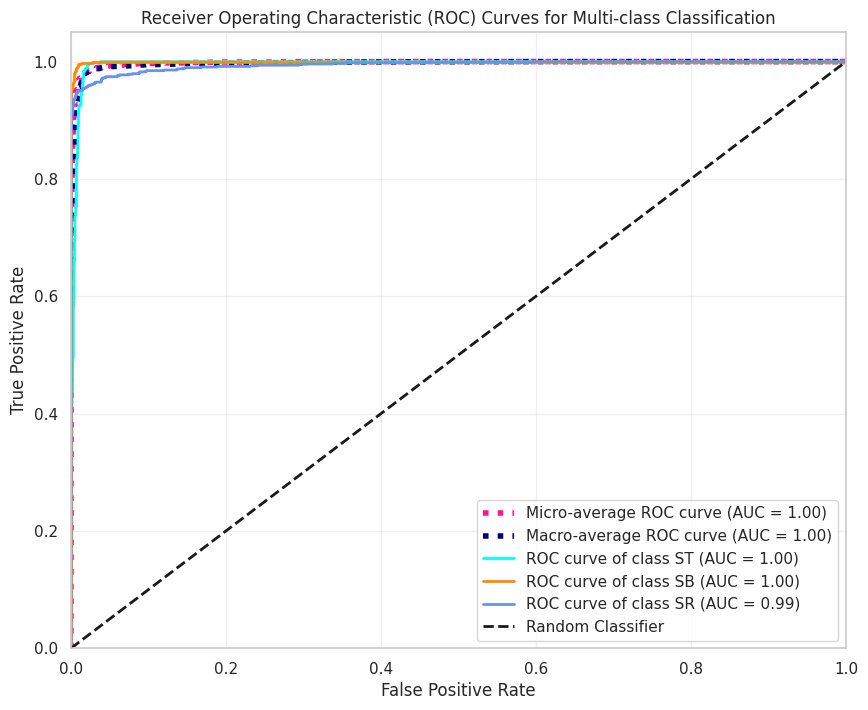

AUC Scores:
Class ST: 0.996
Class SB: 1.000
Class SR: 0.994
Micro-average: 0.998
Macro-average: 0.997


In [21]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels for multi-class ROC
y_test = label_binarize(y_true, classes=[0, 1, 2])
# Use probability scores (not predictions!)
y_score = y_scores  # This contains the probability scores from softmax

n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['ST', 'SB', 'SR']

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_name} (AUC = {roc_auc[i]:0.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print AUC scores
print("AUC Scores:")
for i, class_name in enumerate(['ST', 'SB', 'SR']):
    print(f"Class {class_name}: {roc_auc[i]:.3f}")
print(f"Micro-average: {roc_auc['micro']:.3f}")
print(f"Macro-average: {roc_auc['macro']:.3f}")